Load dataset & convert date to datetime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("train.csv")

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Check data
print(df.head())
print(df.info())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


Aggregate sales by Month

In [3]:
# Set date as index
df.set_index('date', inplace=True)

# Aggregate total sales per month
monthly_sales = df['sales'].resample('M').sum()

monthly_sales.head()

/tmp/ipython-input-4087039733.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['sales'].resample('M').sum()


,sales
date,
2013-01-31,454904
2013-02-28,459417
2013-03-31,617382
2013-04-30,682274
2013-05-31,763242


Plot sales trend over time

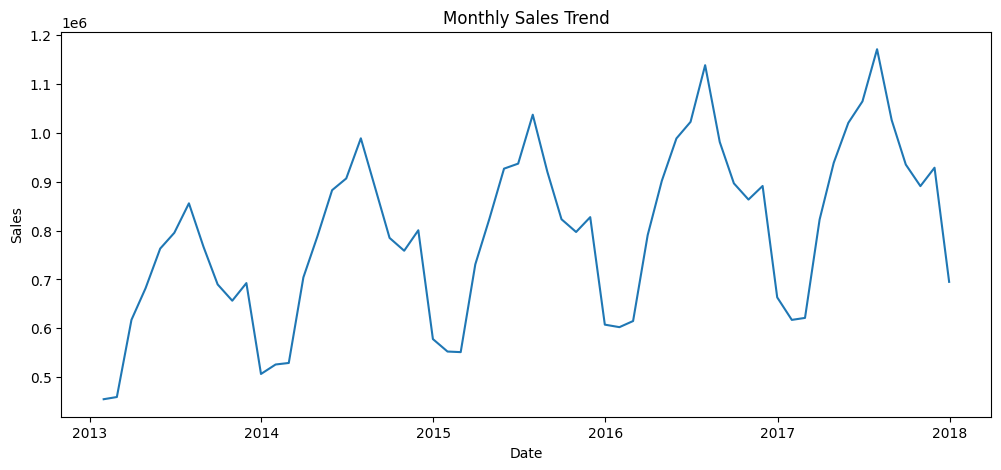

In [4]:
plt.figure(figsize=(12,5))
plt.plot(monthly_sales)
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


Check seasonality using Rolling Mean

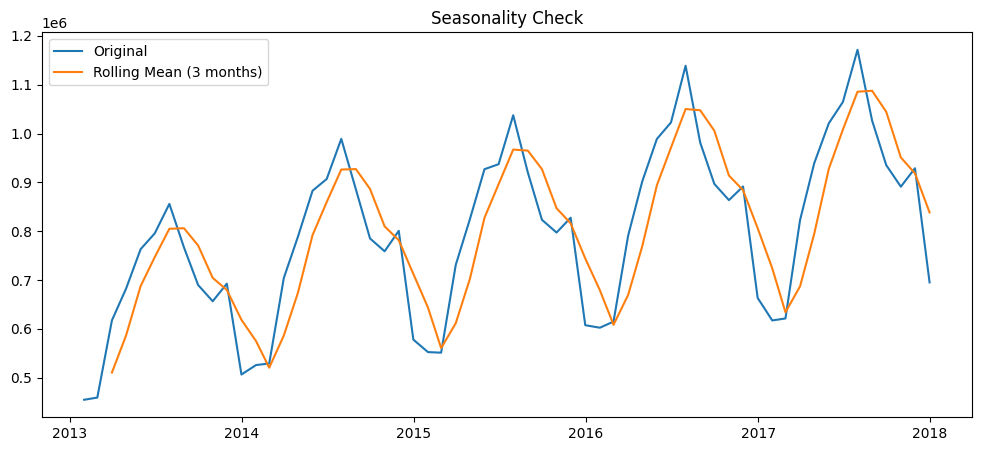

In [5]:
rolling_mean = monthly_sales.rolling(window=3).mean()

plt.figure(figsize=(12,5))
plt.plot(monthly_sales, label='Original')
plt.plot(rolling_mean, label='Rolling Mean (3 months)')
plt.legend()
plt.title("Seasonality Check")
plt.show()


Train/Test Split (Time Based)

In [10]:
# Split last 6 months as test data
train = monthly_sales[:-6]
test = monthly_sales[-6:]

print("Train size:", len(train))
print("Test size:", len(test))

print("Train last date:", train.index.max())
print("Test start date:", test.index.min())



Train size: 54
Test size: 6
Train last date: 2017-06-30 00:00:00
Test start date: 2017-07-31 00:00:00


Fit Forecasting Model (Exponential Smoothing)

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend='add', seasonal=None)
fit_model = model.fit()


Predict & Plot Forecast

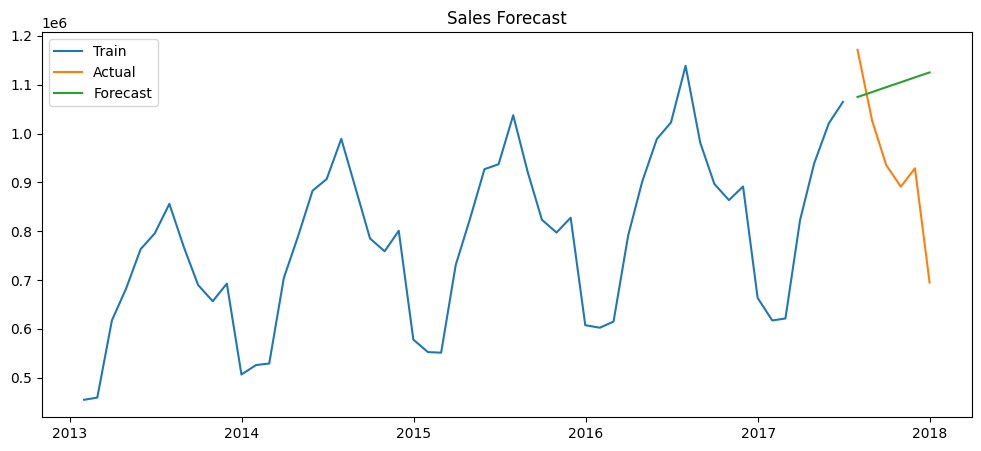

In [12]:
if len(test) == 0:
    # If test is empty, it means we are forecasting truly future values.
    # Let's forecast for a reasonable period, e.g., 12 months.
    forecast_steps = 12
    print(f"Warning: 'test' dataset is empty. Forecasting {forecast_steps} steps beyond training data.")
else:
    forecast_steps = len(test)

forecast = fit_model.forecast(forecast_steps)

plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
# Plot test only if it's not empty, or it won't show anything useful.
if len(test) > 0:
    plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title("Sales Forecast")
plt.show()

Error Metrics (MAE & MAPE)

In [13]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("MAE:", mae)
print("MAPE:", mape)


MAE: 190724.01491950543
MAPE: 22.809927141722987


Export Forecast Results to CSV

In [14]:
forecast_df = pd.DataFrame({
    "Actual": test,
    "Forecast": forecast
})

forecast_df.to_csv("forecast_results.csv")

print("forecast_results.csv saved!")


forecast_results.csv saved!
